In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import obspy
from os.path import join
from sklearn.preprocessing import scale
import pyasdf
%matplotlib inline
import json

In [2]:
df=pd.read_csv("./misfit_withsnr.csv",index_col=0)

In [3]:
snr_df=pd.DataFrame(columns=["gcmtid","depth","process_flag","pz","pr","sz","sr","st","surfz_mt","surfr_mt","pall","svall","shall","surfmtall","theall","theall_nocategory"])

In [4]:
for index,row in df.iterrows():
    pz=row.p_z*1
    pr=row.p_r*0.74
    sz=row.s_z*0.32
    sr=row.s_r*0.28
    st=row.s_t*0.40
    surfz=row.surf_z*0.15
    surfr=row.surf_r*0.17
    
    pall=0.5*(pz+pr)
    svall=0.5*(sz+sr)
    shall=st
    surfmtall=0.5*(row.surf_z_mt+row.surf_r_mt)
    surfall=0.5*(surfz+surfr)
    theall=(pall+svall+shall+surfall)/4
    theall_nocategory=(pall+svall+shall)/3
    
    snr_df.loc[index]=[row.gcmtid,row.depth,row.process_flag,pz,pr,sz,sr,st,row.surf_z_mt,row.surf_r_mt,pall,svall,shall,surfmtall,theall,theall_nocategory]

In [5]:
cmt_dir="/Users/ziyixi/work/seismic-code/fwi-script/visualize/data/cmts"
depth_mapper={}
gcmtid_keys=set(df.gcmtid)
gcmtid_keys=sorted(gcmtid_keys)
for gcmtid in gcmtid_keys:
    depth_mapper[gcmtid]=obspy.read_events(join(cmt_dir,gcmtid))[0].origins[0].depth/1000
depth_range=[-15,-10,-5,0,5,10,15]

In [6]:
def plot_single_figure(gcmtid,process_flag):
    depth=depth_mapper[gcmtid]
    x_perdep=depth_range
    x_acdep=[]
    if(depth<20):
        x_acdep=list(np.linspace(5,depth,4))+[depth+5,depth+10,depth+15]
    else:
        x_acdep=[depth-15,depth-10,depth-5,depth,depth+5,depth+10,depth+15]
    y_p_all,y_sv_all,y_sh_all,y_ray_all,y_theall,y_nocatall=[],[],[],[],[],[]
    df_gcmtid=snr_df[snr_df.gcmtid==gcmtid]
    df_gcmtid_processflag=df_gcmtid[df_gcmtid.process_flag==process_flag]
    for thedepth in depth_range:
        depth_name=f"d{thedepth}"
        df_gcmtid_processflag_depth=df_gcmtid_processflag[df_gcmtid_processflag.depth==depth_name]
        thedf=df_gcmtid_processflag_depth
        
        y_p_all.append(thedf.pall.values[0])
        y_sv_all.append(thedf.svall.values[0])
        y_sh_all.append(thedf.shall.values[0])
        y_ray_all.append(thedf.surfmtall.values[0])
        y_theall.append(thedf.theall.values[0])
        y_nocatall.append(thedf.theall_nocategory.values[0])
    
    # add surf_mt and theall together
    y_theall_withsurf=(((scale(y_theall, axis=0, with_mean=True, with_std=True, copy=True )+scale(y_ray_all, axis=0, with_mean=True, with_std=True, copy=True ))/2)+1)/2
    
    plt.figure(figsize=(14,6))
    plot_list=[y_p_all,y_sv_all,y_sh_all,y_ray_all,y_theall,y_nocatall,y_theall_withsurf]
    plot_name=["p_all","sv_all","sh_all","ray_all","theall","theall_nosurf","theall_withsurfmt"]
    for index,they in enumerate(plot_list):
        ax=plt.subplot(2,4,index+1)
        ax.plot(x_perdep,they,color="k")
        ax.scatter(x_perdep,they,color="r")
        ax.set_title(plot_name[index])
    plt.suptitle(f"{gcmtid},{depth}")
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
    xticks=[f"d{i}({j})" for i,j in zip(x_perdep,x_acdep)]                 
    print(xticks)

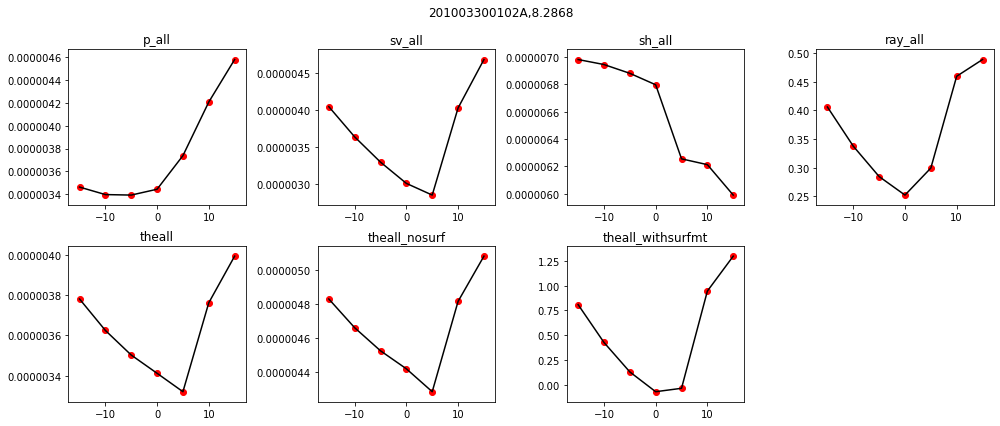

['d-15(5.0)', 'd-10(6.0956)', 'd-5(7.1912)', 'd0(8.2868)', 'd5(13.2868)', 'd10(18.2868)', 'd15(23.2868)']


In [7]:
plot_single_figure("201003300102A","preprocessed_20s_to_120s")

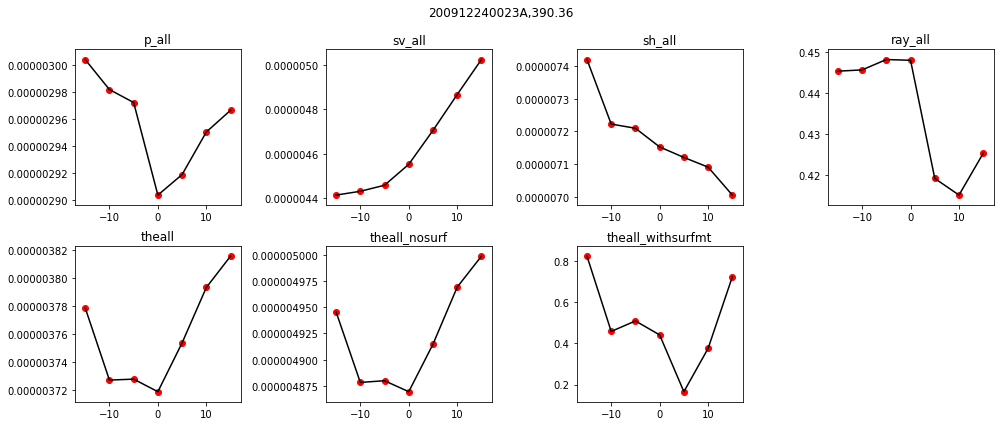

['d-15(375.36)', 'd-10(380.36)', 'd-5(385.36)', 'd0(390.36)', 'd5(395.36)', 'd10(400.36)', 'd15(405.36)']


In [8]:
# 200912240023A
plot_single_figure("200912240023A","preprocessed_20s_to_120s")

In [77]:
def combine_json_dict(body_dict, surf_dict):
    """
    combine the json dict for both the surface wave and the body wave
    """
#     print(body_dict["SC.YYU"])
#     print(surf_dict["SC.YYU"])
    for net_sta in body_dict:
        for level1_key in ["misfit_r", "misfit_t", "misfit_z", "property_times"]:
            for level2_key in body_dict[net_sta][level1_key]:
                body_dict[net_sta][level1_key][level2_key] = body_dict[net_sta][
                    level1_key][level2_key] or surf_dict[net_sta][level1_key][level2_key]

        for level1_key in ["window_length", "amplitude"]:
            for level2_key in body_dict[net_sta][level1_key]:
                for level3_key in body_dict[net_sta][level1_key][level2_key]:
                    body_dict[net_sta][level1_key][level2_key][level3_key] = body_dict[net_sta][level1_key][
                        level2_key][level3_key] or surf_dict[net_sta][level1_key][level2_key][level3_key]
#     print("@@@@")
#     print(body_dict["SC.YYU"])
#     print("@@@@")
    return body_dict


In [10]:
def get_windows(starttime, endtime,  property_times):
    ptime = property_times["first_p"]
    stime = property_times["first_s"]
    surftime = property_times["surface_wave"]
    is_close = property_times["local_station"]
    gcarc = property_times["gcarc"]

    result = {
        "pn": None,
        "p": None,
        "s": None,
        "surf": None
    }

    # different conditions
    if(gcarc < 10):  # local stations
        if(is_close):
            result["pn"] = (starttime, starttime+60)
        else:
            if(ptime < 20):
                result["pn"] = (starttime, starttime+stime)
                result["surf"] = (starttime+stime, starttime+stime+60)
            elif(20 <= ptime < 60):
                result["pn"] = (starttime+ptime-10, starttime+ptime+30)
                result["surf"] = (starttime+stime-10, starttime+stime+110)
            else:
                result["pn"] = (starttime+ptime-20, starttime+ptime+60)
                result["surf"] = (starttime+stime-10, starttime+stime+180)
    else:  # regional stations
        win_surface_start = starttime+surftime - 40
        win_surface_end = starttime+surftime + 180

        result["p"] = (starttime+ptime-20, starttime+ptime+60)
        result["s"] = (starttime+stime-20, starttime+stime+80)
        if(endtime-win_surface_start < 100):
            pass
        elif(win_surface_end > endtime):
            result["surf"] = (win_surface_start, endtime)
        else:
            result["surf"] = (win_surface_start, win_surface_end)

    return result


### Plot a single figure for the use of relocation.

In [11]:
def single_event_relocation(net_sta,data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf):
    # open asdf files
    data_asdf=pyasdf.ASDFDataSet(data_asdf_path,mode="r")
    zero_asdf=pyasdf.ASDFDataSet(zero_asdf_path,mode="r")
    opt_asdf=pyasdf.ASDFDataSet(opt_asdf_path,mode="r")
    # get waveform streams
    data_sg=data_asdf.waveforms[net_sta]
    data_tag=data_sg.get_waveform_tags()[0]
    data_st=data_sg[data_tag].copy()
    zero_sg=zero_asdf.waveforms[net_sta]
    zero_tag=zero_sg.get_waveform_tags()[0]
    zero_st=zero_sg[zero_tag].copy()
    opt_sg=opt_asdf.waveforms[net_sta]
    opt_tag=opt_sg.get_waveform_tags()[0]
    opt_st=opt_sg[opt_tag].copy() 
    # get windows information
    windows_body_dict=None
    windows_surf_dict=None
    with open(windows_json_body,"r") as f:
        windows_body_dict=json.load(f)
    with open(windows_json_surf,"r") as f:
        windows_surf_dict=json.load(f)
    windows_dict=combine_json_dict(windows_body_dict, windows_surf_dict)
    # get windows
    property_times=windows_dict[net_sta]["property_times"]
    starttime=data_st[0].stats.starttime
    endtime=data_st[0].stats.endtime
    windows=get_windows(starttime, endtime,  property_times)
    
    ##################
    # plot zero
    plt.figure(figsize=(14,30))
    x_data=None
    x_sync=None
    y_data=None
    y_sync=None
    
    # pz
    ax_pz=plt.subplot(7,2,1)
    if(windows["pn"]):
        trace_data=data_st[2].slice(windows["pn"][0],windows["pn"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[2].slice(windows["pn"][0],windows["pn"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    elif(windows["p"]):
        trace_data=data_st[2].slice(windows["p"][0],windows["p"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[2].slice(windows["p"][0],windows["p"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax_pz.plot(x_data,y_data,color="k")
    ax_pz.plot(x_sync,y_sync,color="r")
    ax_pz.set_title("raw")
    ax_pz.set_ylabel("pz",fontsize=28)
    
    # pr
    ax_pr=plt.subplot(7,2,3)
    if(windows["pn"]):
        trace_data=data_st[0].slice(windows["pn"][0],windows["pn"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[0].slice(windows["pn"][0],windows["pn"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    elif(windows["p"]):
        trace_data=data_st[0].slice(windows["p"][0],windows["p"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[0].slice(windows["p"][0],windows["p"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax_pr.plot(x_data,y_data,color="k")
    ax_pr.plot(x_sync,y_sync,color="r")
    ax_pr.set_ylabel("pr",fontsize=28)
    
    # sz
    ax_sz=plt.subplot(7,2,5)
    if(windows["s"]):
        trace_data=data_st[2].slice(windows["s"][0],windows["s"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[2].slice(windows["s"][0],windows["s"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax_sz.plot(x_data,y_data,color="k")
    ax_sz.plot(x_sync,y_sync,color="r")  
    ax_sz.set_ylabel("sz",fontsize=28)
    
    # sr
    ax_sr=plt.subplot(7,2,7)
    if(windows["s"]):
        trace_data=data_st[0].slice(windows["s"][0],windows["s"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[0].slice(windows["s"][0],windows["s"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax_sr.plot(x_data,y_data,color="k")
    ax_sr.plot(x_sync,y_sync,color="r")
    ax_sr.set_ylabel("sr",fontsize=28)
    
    # st
    ax_st=plt.subplot(7,2,9)
    if(windows["s"]):
        trace_data=data_st[1].slice(windows["s"][0],windows["s"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[1].slice(windows["s"][0],windows["s"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax_st.plot(x_data,y_data,color="k")
    ax_st.plot(x_sync,y_sync,color="r")
    ax_st.set_ylabel("st",fontsize=28)
    
    # ray z
    ax_rayz=plt.subplot(7,2,11)
    if(windows["surf"]):
        trace_data=data_st[2].slice(windows["surf"][0],windows["surf"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[2].slice(windows["surf"][0],windows["surf"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax_rayz.plot(x_data,y_data,color="k")
    ax_rayz.plot(x_sync,y_sync,color="r")    
    ax_rayz.set_ylabel("rayz",fontsize=28)
    
    # ray r
    ax_rayr=plt.subplot(7,2,13)
    if(windows["surf"]):
        trace_data=data_st[0].slice(windows["surf"][0],windows["surf"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=zero_st[0].slice(windows["surf"][0],windows["surf"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax_rayr.plot(x_data,y_data,color="k")
    ax_rayr.plot(x_sync,y_sync,color="r")  
    plt.tight_layout()
    ax_rayr.set_ylabel("rayr",fontsize=28)
    ##############################

    ##################
    # plot opt
    x_data=None
    x_sync=None
    y_data=None
    y_sync=None
    
    # pz
    ax=plt.subplot(7,2,2,sharey=ax_pz)
    if(windows["pn"]):
        trace_data=data_st[2].slice(windows["pn"][0],windows["pn"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[2].slice(windows["pn"][0],windows["pn"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    elif(windows["p"]):
        trace_data=data_st[2].slice(windows["p"][0],windows["p"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[2].slice(windows["p"][0],windows["p"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax.plot(x_data,y_data,color="k")
    ax.plot(x_sync,y_sync,color="r")
    ax.set_title("opt")
    
    # pr
    ax=plt.subplot(7,2,4,sharey=ax_pr)
    if(windows["pn"]):
        trace_data=data_st[0].slice(windows["pn"][0],windows["pn"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[0].slice(windows["pn"][0],windows["pn"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    elif(windows["p"]):
        trace_data=data_st[0].slice(windows["p"][0],windows["p"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[0].slice(windows["p"][0],windows["p"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax.plot(x_data,y_data,color="k")
    ax.plot(x_sync,y_sync,color="r")  
    
    # sz
    ax=plt.subplot(7,2,6,sharey=ax_sz)
    if(windows["s"]):
        trace_data=data_st[2].slice(windows["s"][0],windows["s"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[2].slice(windows["s"][0],windows["s"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax.plot(x_data,y_data,color="k")
    ax.plot(x_sync,y_sync,color="r")  
    
    # sr
    ax=plt.subplot(7,2,8,sharey=ax_sr)
    if(windows["s"]):
        trace_data=data_st[0].slice(windows["s"][0],windows["s"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[0].slice(windows["s"][0],windows["s"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax.plot(x_data,y_data,color="k")
    ax.plot(x_sync,y_sync,color="r")
    
    # st
    ax=plt.subplot(7,2,10,sharey=ax_st)
    if(windows["s"]):
        trace_data=data_st[1].slice(windows["s"][0],windows["s"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[1].slice(windows["s"][0],windows["s"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax.plot(x_data,y_data,color="k")
    ax.plot(x_sync,y_sync,color="r")
    
    # ray z
    ax=plt.subplot(7,2,12,sharey=ax_rayz)
    if(windows["surf"]):
        trace_data=data_st[2].slice(windows["surf"][0],windows["surf"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[2].slice(windows["surf"][0],windows["surf"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax.plot(x_data,y_data,color="k")
    ax.plot(x_sync,y_sync,color="r")     
    
    # ray r
    ax=plt.subplot(7,2,14,sharey=ax_rayr)
    if(windows["surf"]):
        trace_data=data_st[0].slice(windows["surf"][0],windows["surf"][1])
        x_data=np.linspace(0,trace_data.stats.endtime-trace_data.stats.starttime,trace_data.stats.npts)
        y_data=trace_data.data
        trace_sync=opt_st[0].slice(windows["surf"][0],windows["surf"][1])
        x_sync=np.linspace(0,trace_sync.stats.endtime-trace_sync.stats.starttime,trace_sync.stats.npts)
        y_sync=trace_sync.data
    ax.plot(x_data,y_data,color="k")
    ax.plot(x_sync,y_sync,color="r") 
    plt.tight_layout()
    ##############################
    
    plt.show()

# In the below we test different events. (we only consider 20s at the moment)

In [50]:
def load_data(raw_dep,opt_dep,data_dir=None,sync_dir=None,window_dir=None,gcmtid=None):
    data_asdf_path=f"{data_dir}/raw_{gcmtid}.preprocessed_20s_to_120s.h5"
    zero_asdf_path=f"{sync_dir}/sync_{gcmtid}_d{raw_dep}_raw.preprocessed_20s_to_120s.h5"
    opt_asdf_path=f"{sync_dir}/sync_{gcmtid}_d{opt_dep}_raw.preprocessed_20s_to_120s.h5"
    windows_json_body=f"{window_dir}/{gcmtid}.d{raw_dep}.preprocessed_20s_to_120s.body.json"
    windows_json_surf=f"{window_dir}/{gcmtid}.d{raw_dep}.preprocessed_20s_to_120s.surf.json"    
    return data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf

In [99]:
def get_used_phases(stname,gcmtid,window_dir=None):
    windows_json_body=f"{window_dir}/{gcmtid}.d0.preprocessed_20s_to_120s.body.json"
    windows_json_surf=f"{window_dir}/{gcmtid}.d0.preprocessed_20s_to_120s.surf.json"
    
    with open(windows_json_body,"r") as f:
        windows_body_dict=json.load(f)
    with open(windows_json_surf,"r") as f:
        windows_surf_dict=json.load(f)
    st_json_dict=combine_json_dict(windows_body_dict, windows_surf_dict)
    status={
        "pz":(st_json_dict[stname]["misfit_z"]["p"] or st_json_dict[stname]["misfit_z"]["pn"]) and (st_json_dict[stname]["amplitude"]["z"]["p"] or st_json_dict[stname]["amplitude"]["z"]["pn"]),
        "pr":(st_json_dict[stname]["misfit_r"]["p"] or st_json_dict[stname]["misfit_r"]["pn"]) and (st_json_dict[stname]["amplitude"]["r"]["p"] or st_json_dict[stname]["amplitude"]["r"]["pn"]),
        "sz":st_json_dict[stname]["misfit_z"]["s"] and st_json_dict[stname]["amplitude"]["z"]["s"],
        "sr":st_json_dict[stname]["misfit_r"]["s"] and st_json_dict[stname]["amplitude"]["r"]["s"],
        "st":st_json_dict[stname]["misfit_t"]["s"] and st_json_dict[stname]["amplitude"]["t"]["s"],
        "rayz":st_json_dict[stname]["misfit_z"]["surf"] and st_json_dict[stname]["amplitude"]["z"]["surf"],
        "rayr":st_json_dict[stname]["misfit_r"]["surf"] and st_json_dict[stname]["amplitude"]["r"]["surf"]
    }
    return status
    

## 201003300102A

In [39]:
from functools import partial
load_data_201003300102A=partial(load_data,data_dir="./relocation_newweight",sync_dir="./relocation_newweight",window_dir="./relocation_newweight",gcmtid="201003300102A")

{'pz': 3.103876263680821e-06, 'pr': 2.9210383308691333e-06, 'sz': 1.1122821824549847e-05, 'sr': 4.072834268947859e-05, 'st': 1.2807013051329285e-05, 'rayz': 0.0894529135358513, 'rayr': 0.26063159927394414}


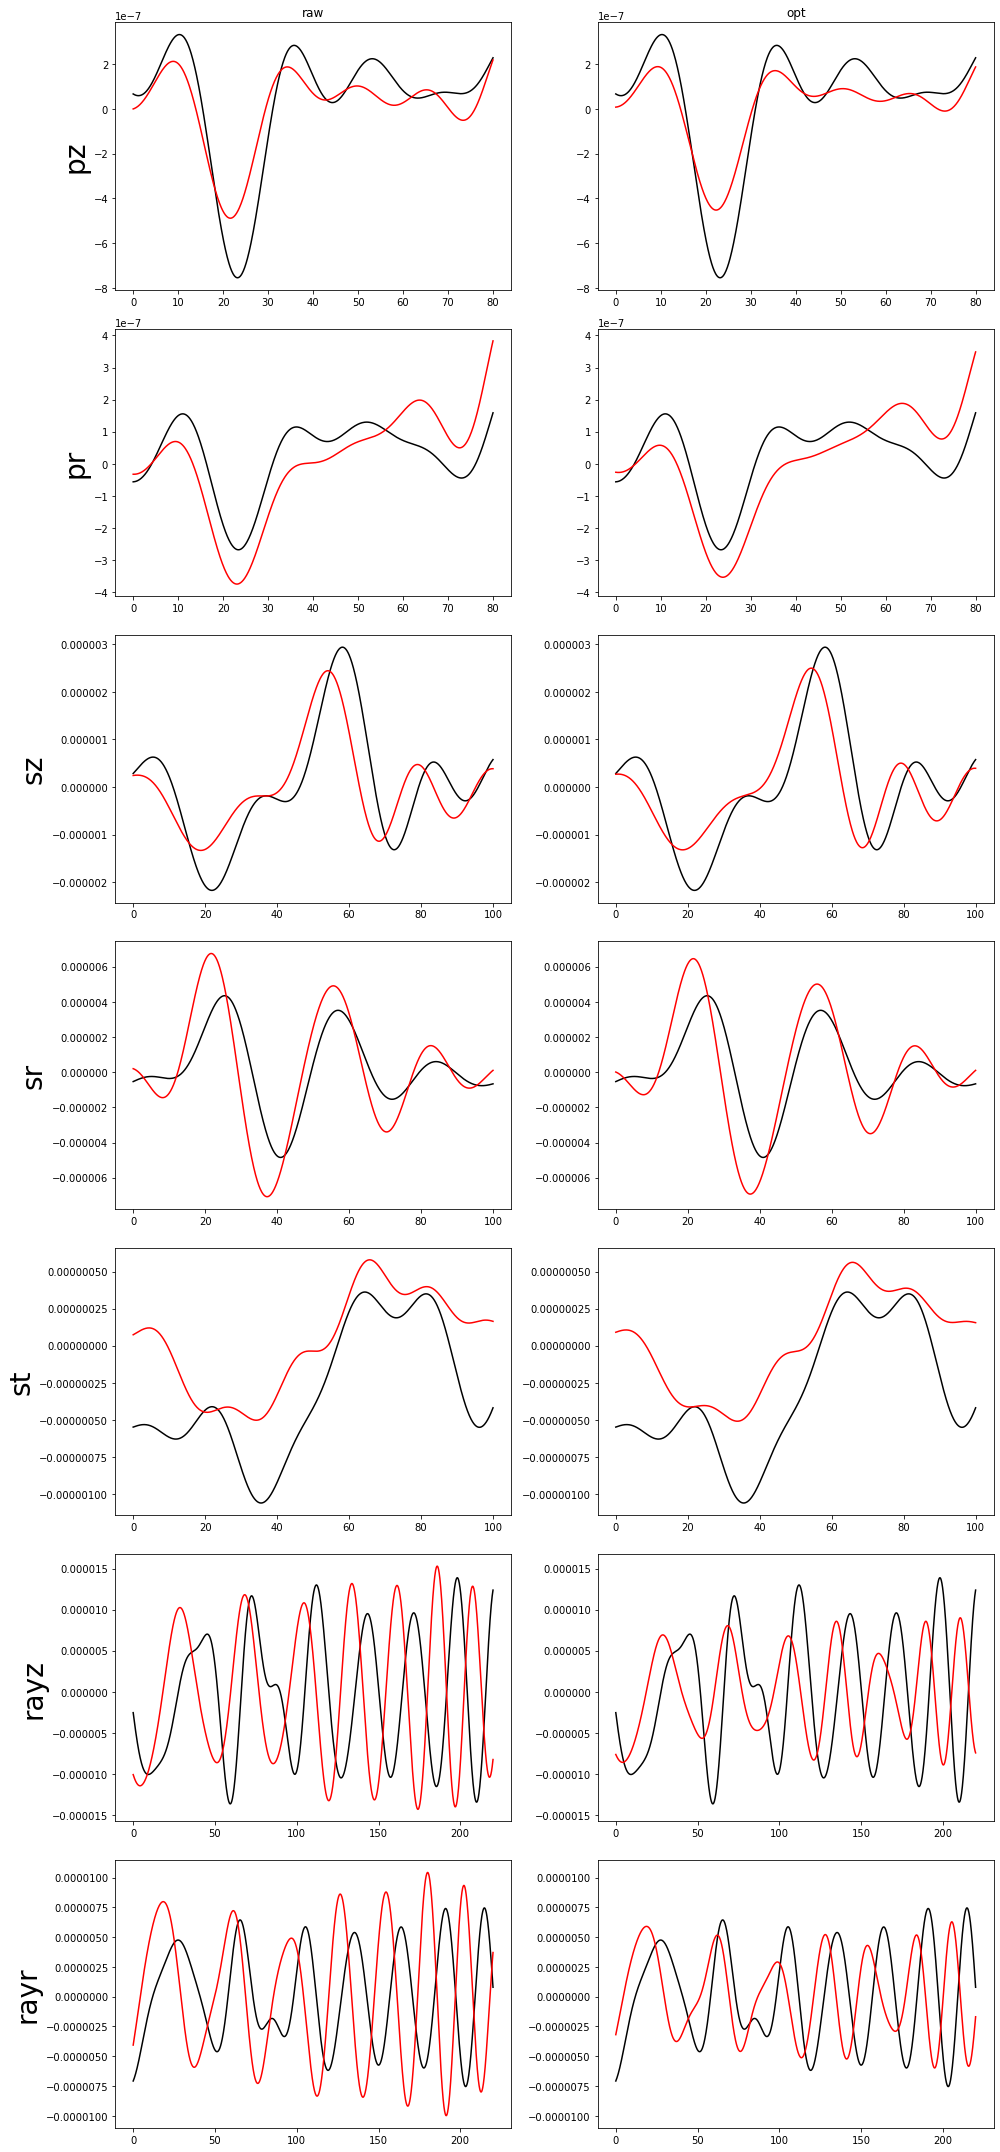

In [33]:
net_sta="CB.GOM"
data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf=load_data_201003300102A(0,5)
print(get_used_phases(net_sta,window_dir="./relocation_newweight"))

single_event_relocation(net_sta,data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf)

{'pz': 3.8134889035780353e-06, 'pr': 1.230548466771778e-05, 'sz': 2.482900646328751e-05, 'sr': 9.080985693411418e-05, 'st': 1.9002085318000517e-05, 'rayz': 0.23560661650299194, 'rayr': 0.10837012399128891}


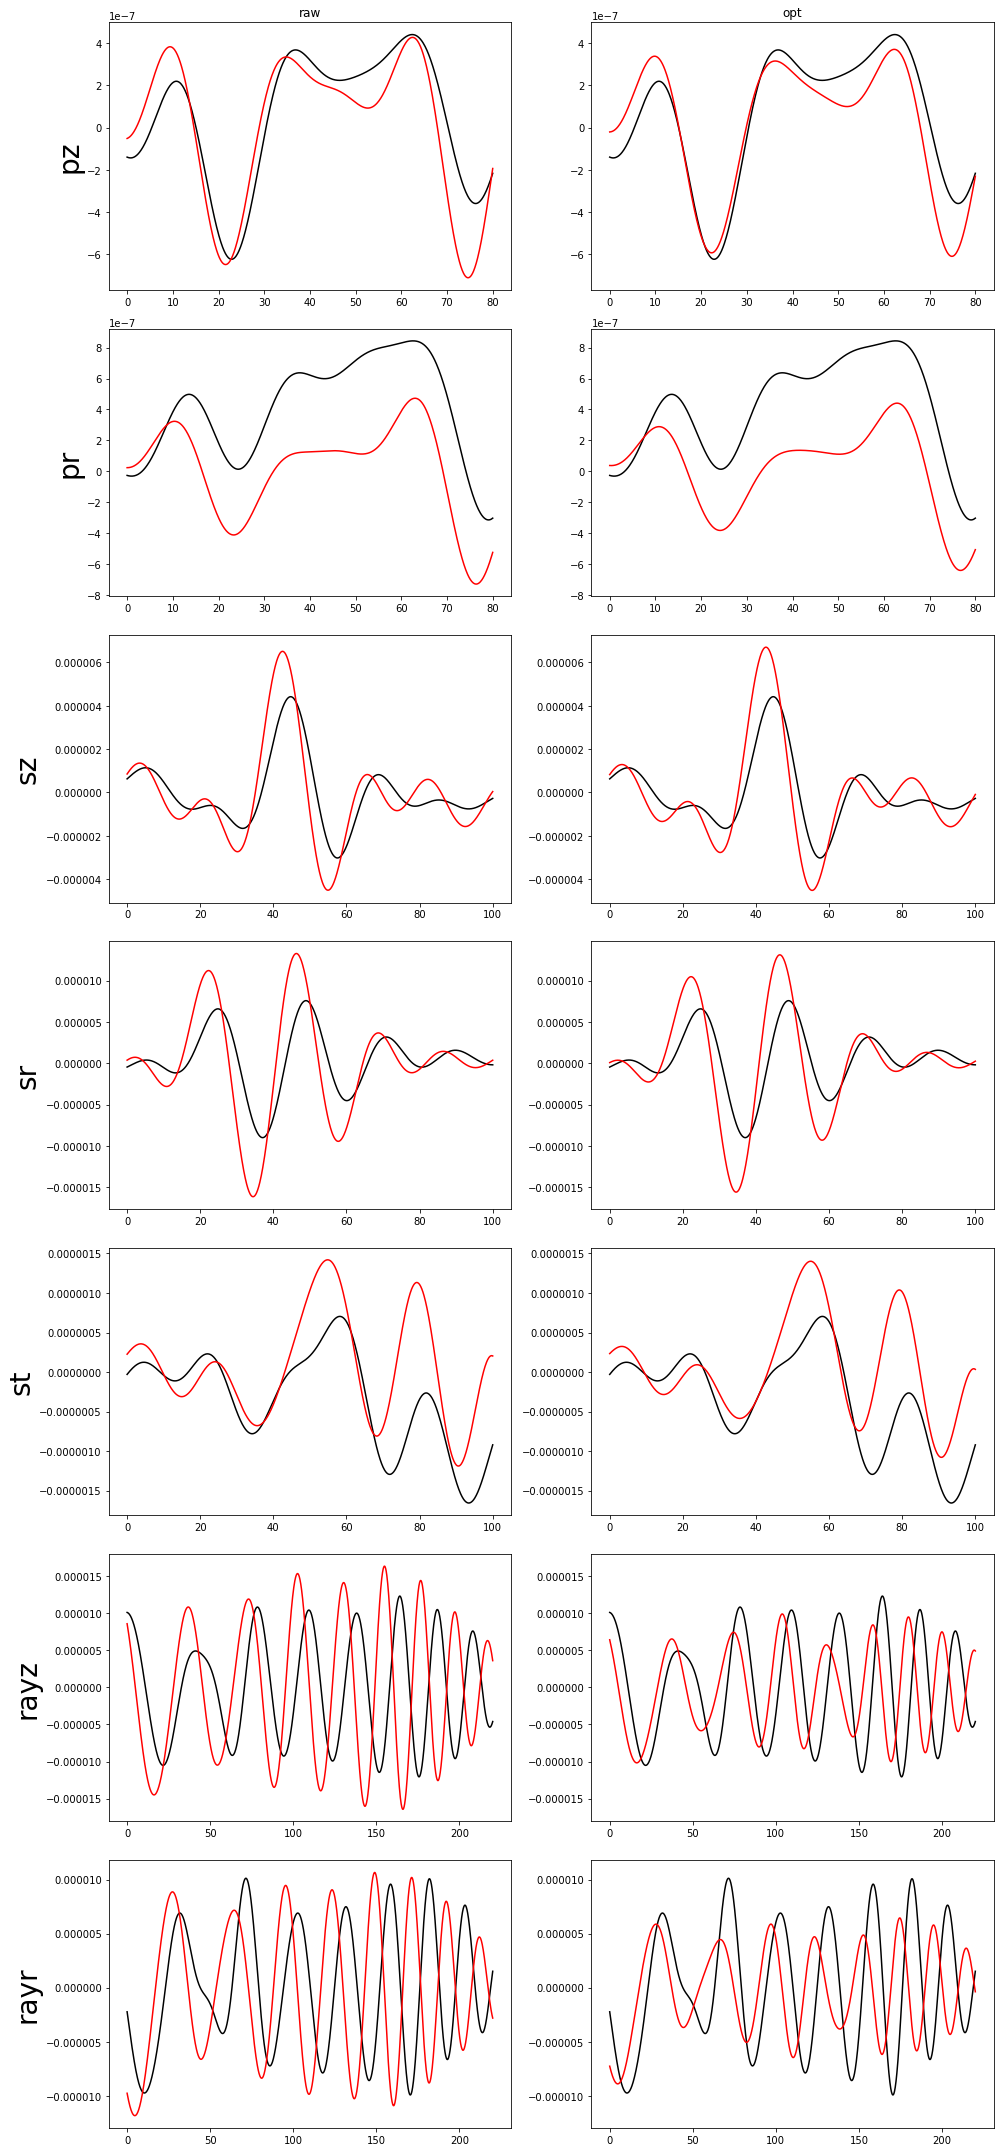

In [36]:
net_sta="QH.QIL"
data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf=load_data_201003300102A(0,5)
print(get_used_phases(net_sta,window_dir="./relocation_newweight"))

single_event_relocation(net_sta,data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf)

## 200912240023A

In [52]:
from functools import partial
load_data_200912240023A=partial(load_data,data_dir="./relocation_newweight",sync_dir="./relocation_newweight",window_dir="./relocation_newweight",gcmtid="200912240023A")

{'pz': 3.763673248613486e-06, 'pr': 4.173267825535731e-06, 'sz': 4.89529566038982e-06, 'sr': 4.665362212108448e-06, 'st': 9.685839359008241e-06, 'rayz': 6.593086254724767e-06, 'rayr': 5.081325980427209e-06}


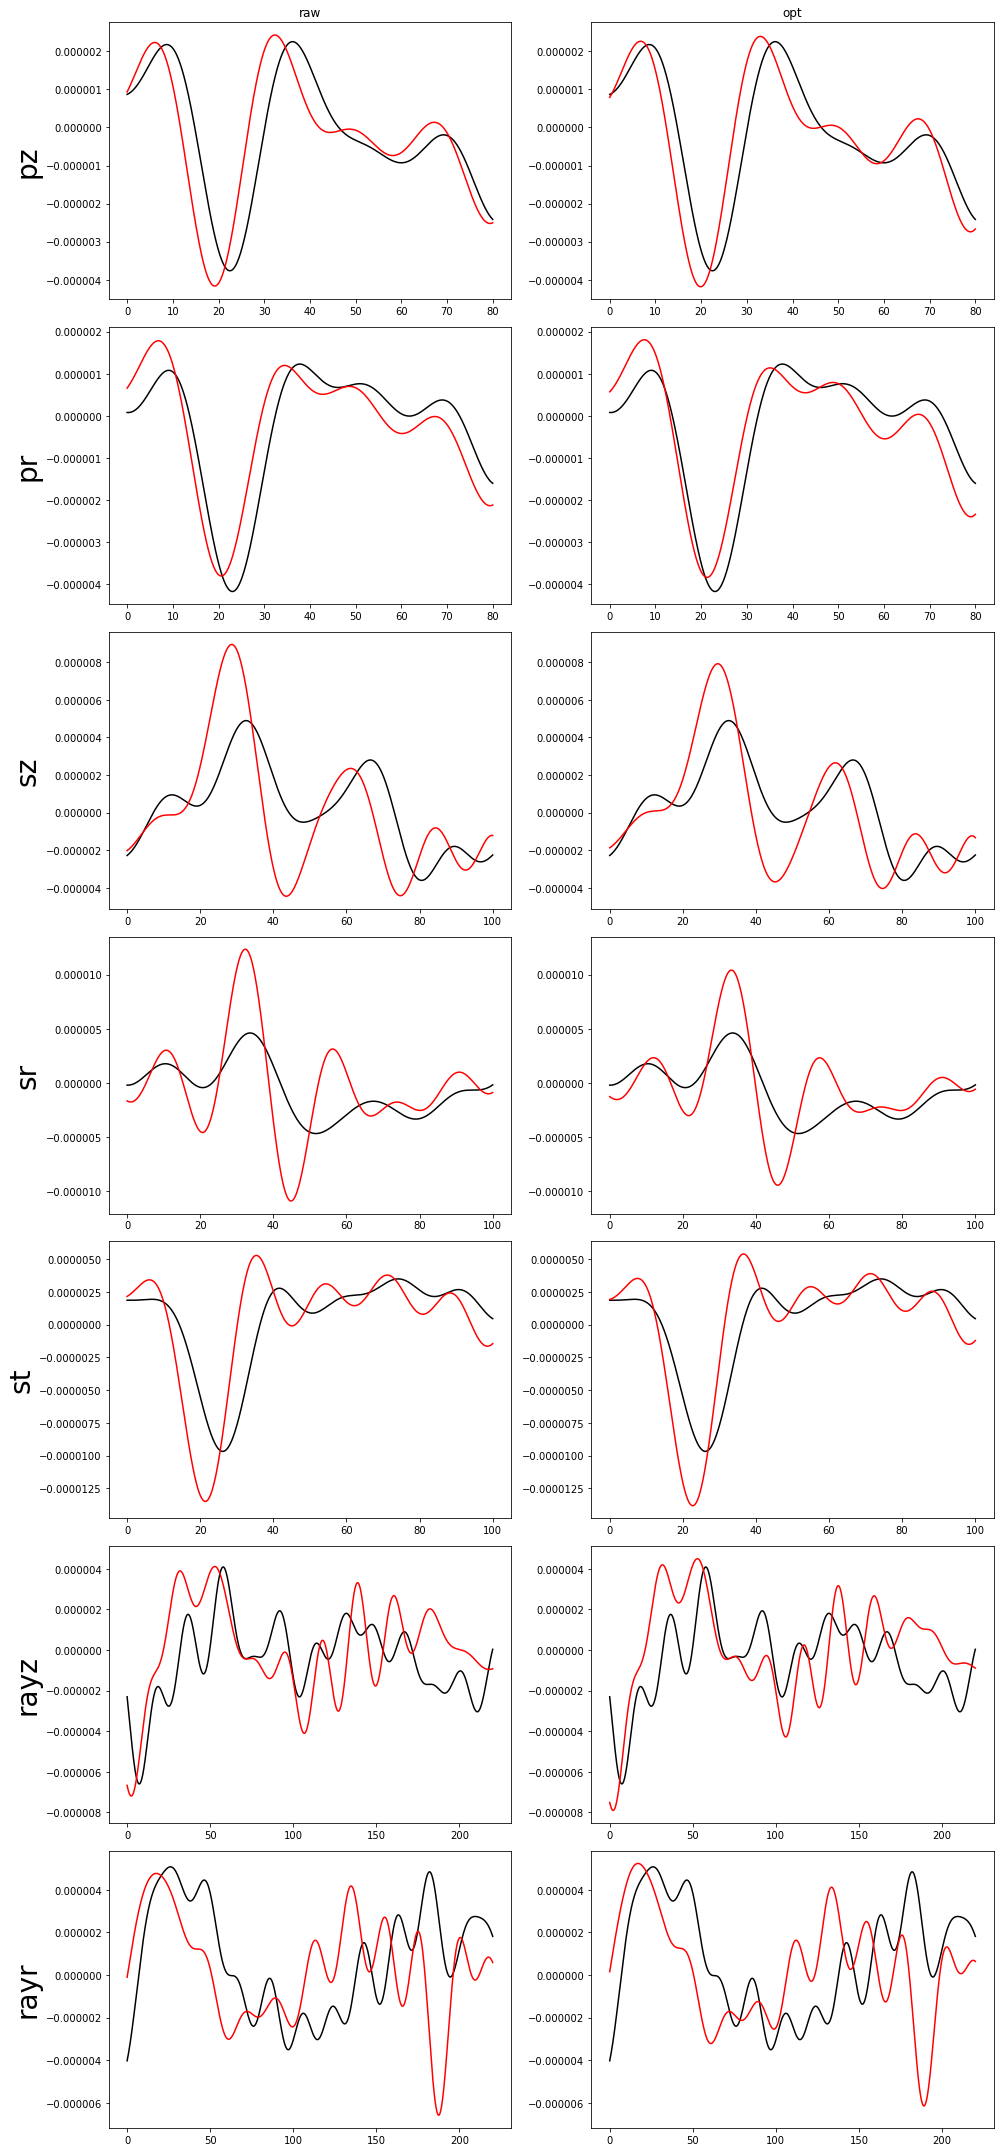

In [103]:
net_sta="GS.ZHC"
data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf=load_data_200912240023A(0,-10)
print(get_used_phases(net_sta,"200912240023A",window_dir="./relocation_newweight"))

single_event_relocation(net_sta,data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf)

{'pz': 5.958036126685329e-06, 'pr': 6.133124770713039e-06, 'sz': 1.3056745046924334e-05, 'sr': 6.979464615142206e-06, 'st': 8.412765055254567e-06, 'rayz': None, 'rayr': None}


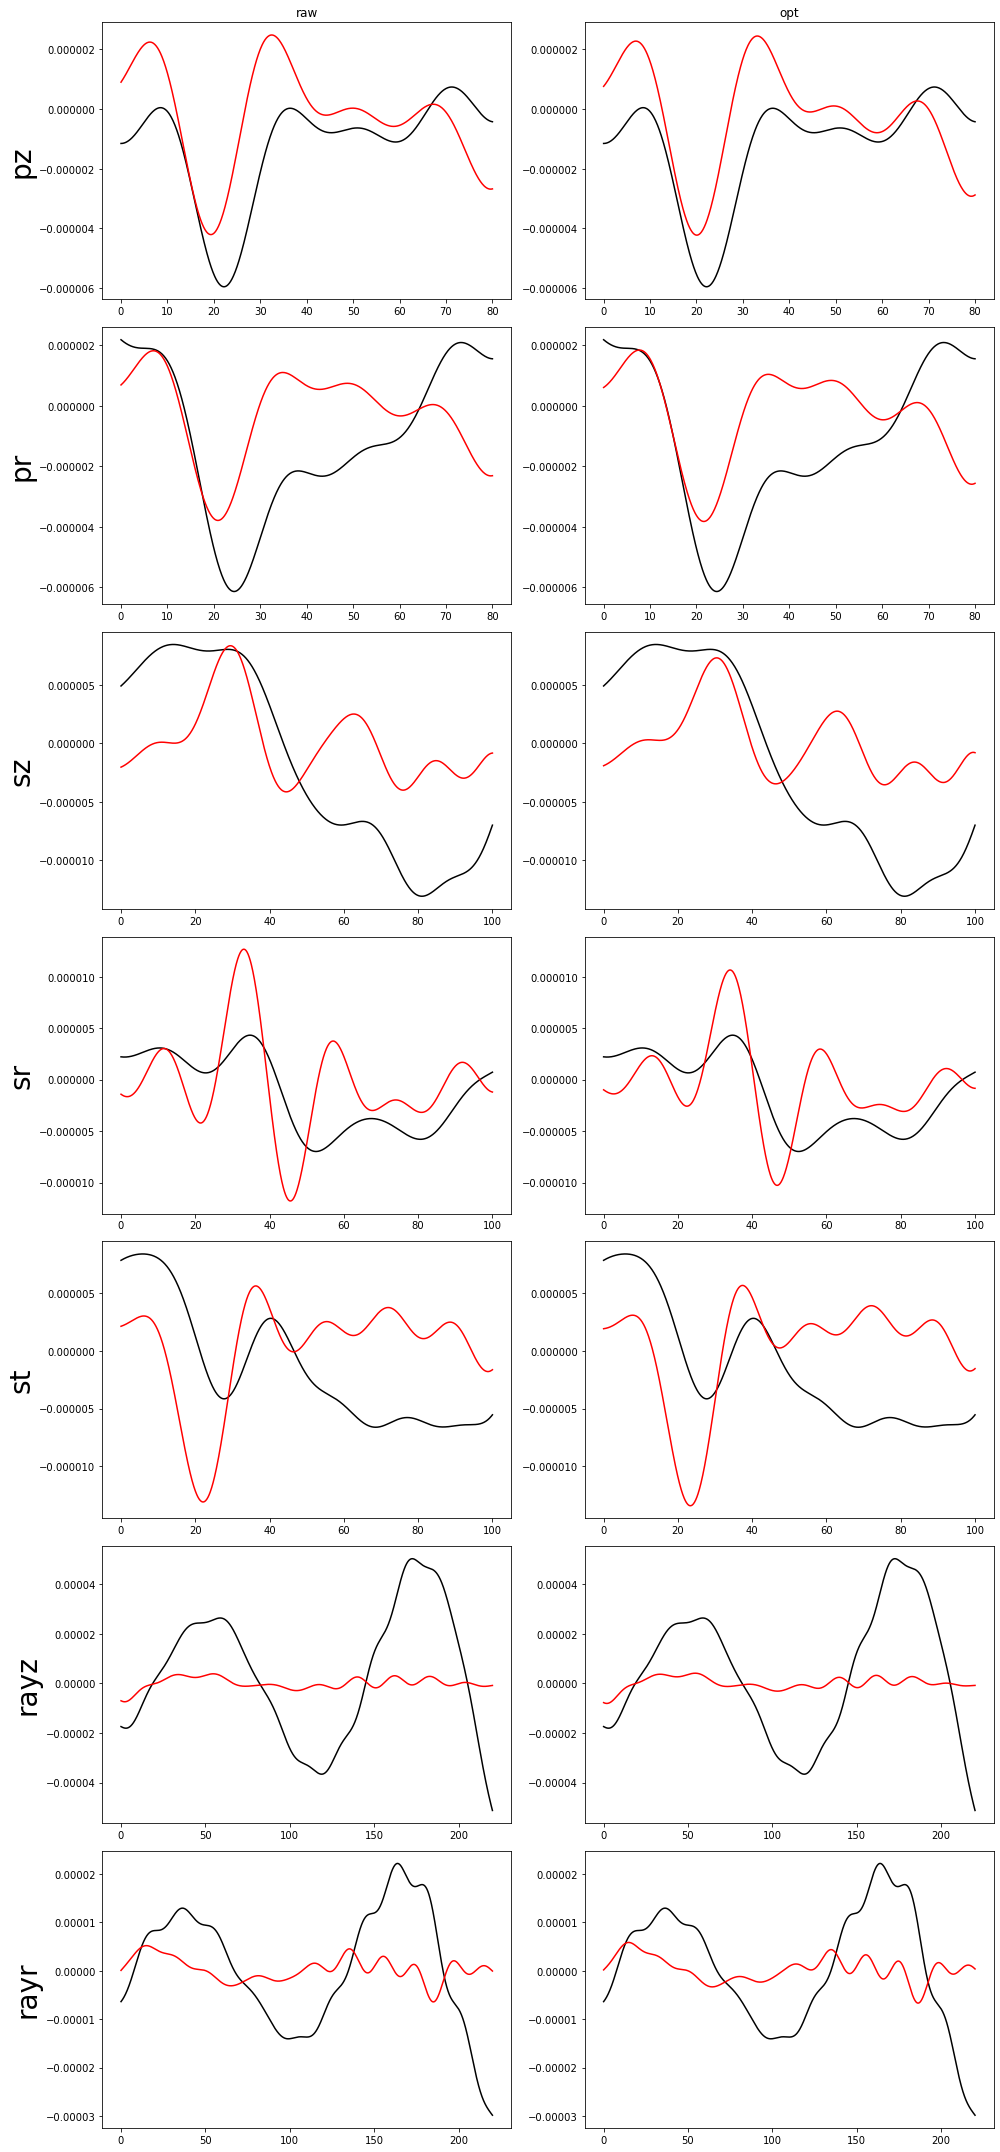

In [108]:
net_sta="GS.JNT"
data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf=load_data_200912240023A(0,-10)
print(get_used_phases(net_sta,"200912240023A",window_dir="./relocation_newweight"))

single_event_relocation(net_sta,data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf)

{'pz': 5.771472842752701e-06, 'pr': 4.168337909504771e-06, 'sz': 7.322061264858348e-06, 'sr': 6.369853053911356e-06, 'st': 1.3760176443611272e-05, 'rayz': 4.460173386178212e-06, 'rayr': 6.620716249017278e-06}


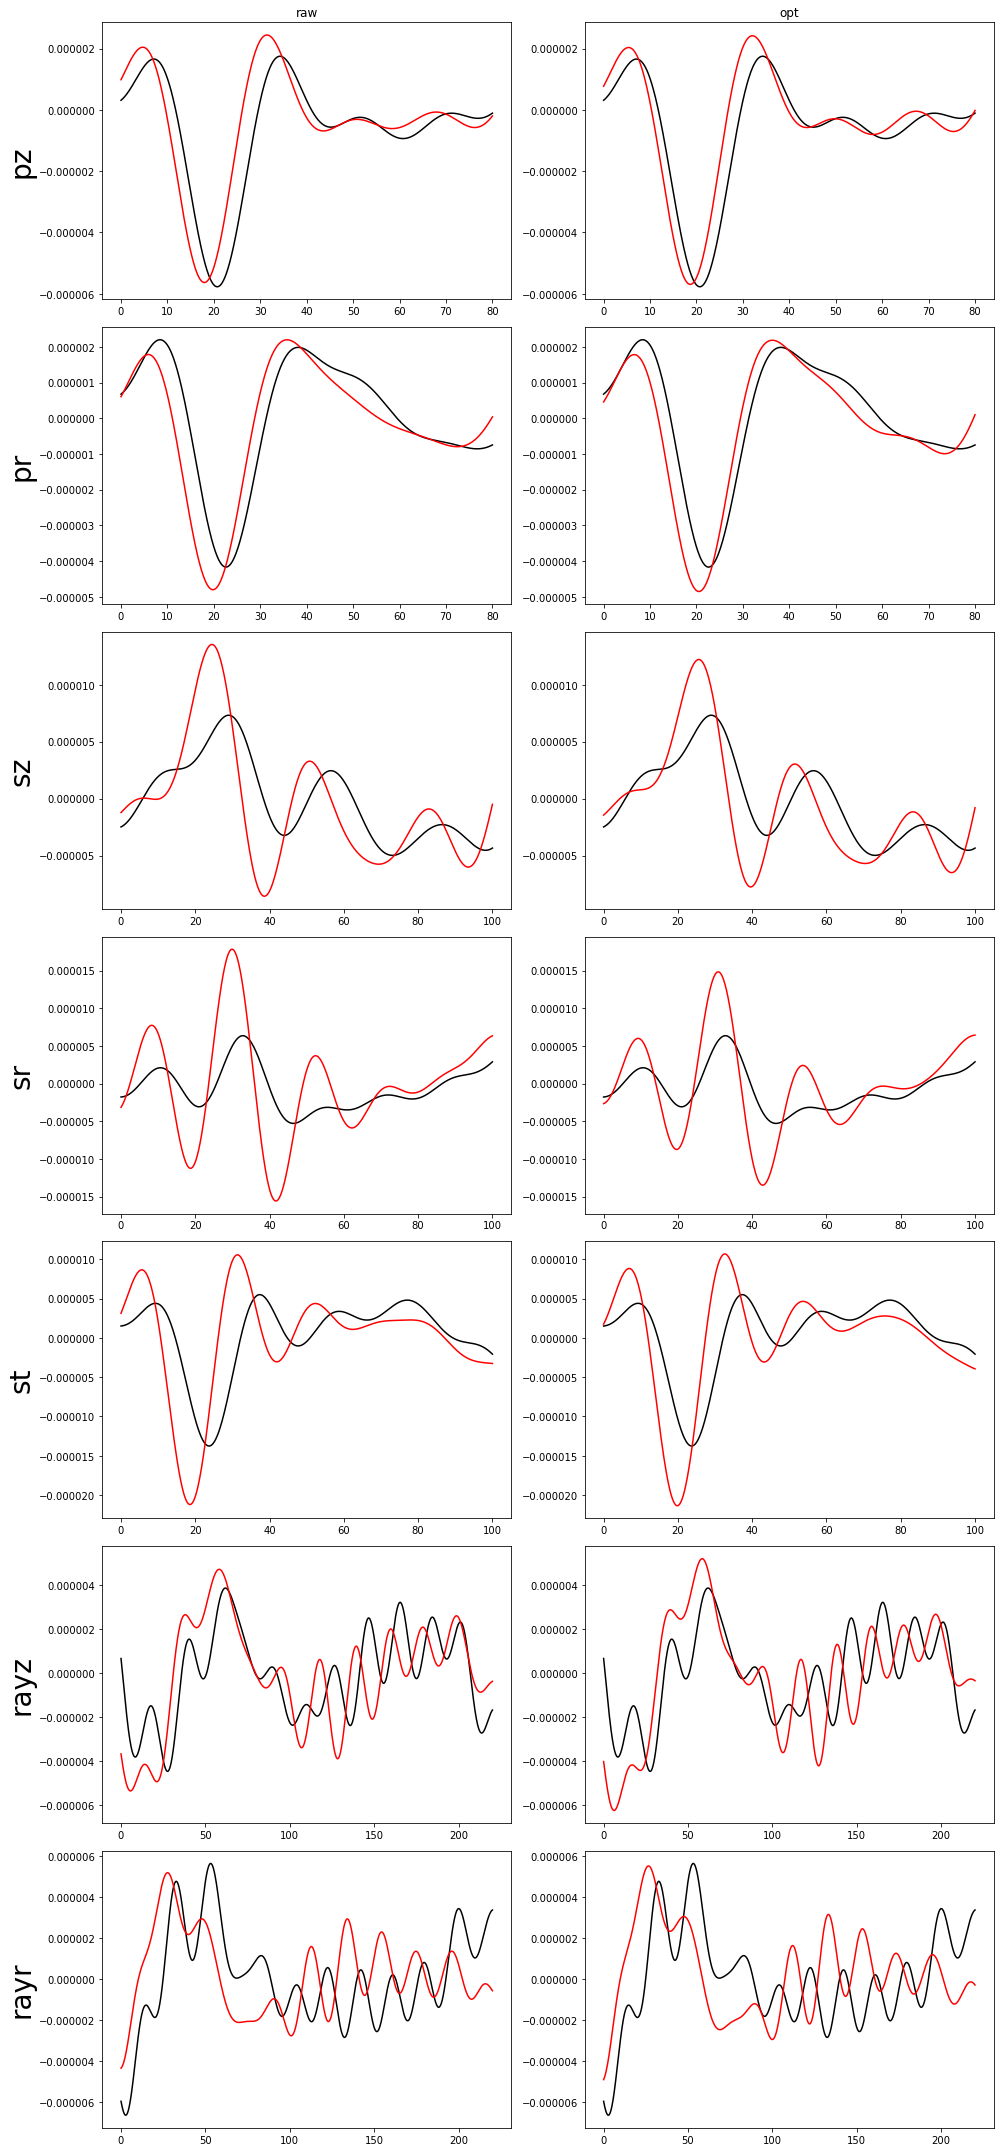

In [109]:
net_sta="GS.HCH"
data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf=load_data_200912240023A(0,-10)
print(get_used_phases(net_sta,"200912240023A",window_dir="./relocation_newweight"))

single_event_relocation(net_sta,data_asdf_path,zero_asdf_path,opt_asdf_path,windows_json_body,windows_json_surf)